In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import tensorflow
from tensorflow import keras 

In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid


In [ ]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
BATCH_SIZE = 128

True
True
cuda:0


In [ ]:
from keras.datasets import cifar10, mnist, fashion_mnist
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

In [ ]:
def sumerizeDataset(trainImages:np.array, labels:np.array):
    print(trainImages.shape, labels.shape)
    print("maxpixel : ", np.max(trainImages),"| minpixel : ", np.min(trainImages))
    print("calsses : ", np.unique(labels))
    

In [ ]:
sumerizeDataset(cifar10_x_train, cifar10_y_train)
sumerizeDataset(mnist_x_train, mnist_y_train)
sumerizeDataset(fashion_mnist_x_train, fashion_mnist_y_train)

(50000, 32, 32, 3) (50000, 1)
maxpixel :  255 | minpixel :  0
calsses :  [0 1 2 3 4 5 6 7 8 9]
(60000, 28, 28) (60000,)
maxpixel :  255 | minpixel :  0
calsses :  [0 1 2 3 4 5 6 7 8 9]
(60000, 28, 28) (60000,)
maxpixel :  255 | minpixel :  0
calsses :  [0 1 2 3 4 5 6 7 8 9]


# Data Preprocess

In [ ]:
def preprocess(Xtrain,ytrain, Xtest, ytest):
    if(len(Xtrain.shape) == 4):
    
        Xtrain = Xtrain.transpose(0, 3, 1, 2)
        Xtest = Xtest.transpose(0, 3, 1, 2)

    elif(len(Xtrain.shape) == 3):
        Xtrain = Xtrain[:,:,:,np.newaxis]
        print(Xtrain.shape)
        Xtest = Xtest[:,:,:,np.newaxis]
        Xtrain = Xtrain.transpose(0,3, 1, 2)
        Xtest = Xtest.transpose(0,3, 1, 2)

    ytrain = ytrain.reshape((ytrain.shape[0],))
    ytest = ytest.reshape((ytest.shape[0],))
    assert ytrain.shape == (ytrain.shape[0],), "Please change labels shape to (:,1)"
    assert ytest.shape == (ytest.shape[0],),  "Please change labels shape to (:,1)"

    return (Xtrain, ytrain), (Xtest, ytest)


In [ ]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = preprocess(cifar10_x_train, cifar10_y_train, cifar10_x_test, cifar10_y_test) 
sumerizeDataset(cifar10_x_train, cifar10_y_train)
print("------------------------------------------------")
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test)= preprocess(mnist_x_train, mnist_y_train, mnist_x_test, mnist_y_test)
sumerizeDataset(mnist_x_train, mnist_y_train)
print("------------------------------------------------")
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = preprocess(fashion_mnist_x_train, fashion_mnist_y_train, fashion_mnist_x_test, fashion_mnist_y_test) 
sumerizeDataset(fashion_mnist_x_train, fashion_mnist_y_train)
print("------------------------------------------------")



(50000, 3, 32, 32) (50000,)
maxpixel :  255 | minpixel :  0
calsses :  [0 1 2 3 4 5 6 7 8 9]
------------------------------------------------
(60000, 28, 28, 1)
(60000, 1, 28, 28) (60000,)
maxpixel :  255 | minpixel :  0
calsses :  [0 1 2 3 4 5 6 7 8 9]
------------------------------------------------
(60000, 28, 28, 1)
(60000, 1, 28, 28) (60000,)
maxpixel :  255 | minpixel :  0
calsses :  [0 1 2 3 4 5 6 7 8 9]
------------------------------------------------


## Normalization and One Hot Encoding

In [ ]:
def torchDataset(Xtrain, ytrain, Xtest, ytest ):
    Xtrain = torch.tensor(Xtrain)/255.0
    ytrain = F.one_hot(torch.tensor(ytrain).type(torch.LongTensor), num_classes = 10).float()
    Xtest = torch.tensor(Xtest)/255.0
    ytest = F.one_hot(torch.tensor(ytest).type(torch.LongTensor), num_classes = 10).float()
    trainTensor = TensorDataset(Xtrain, ytrain)
    testTensor = TensorDataset(Xtest, ytest)

    return  trainTensor, testTensor

In [ ]:
cfar10train, cfar10test = torchDataset(cifar10_x_train, cifar10_y_train, cifar10_x_test, cifar10_y_test) 
mnisttrain, mnisttest = torchDataset(mnist_x_train, mnist_y_train, mnist_x_test, mnist_y_test)
fashionmnisttrain,fashionmnistest = torchDataset(fashion_mnist_x_train, fashion_mnist_y_train, fashion_mnist_x_test, fashion_mnist_y_test) 


In [ ]:
cfar10trainLoader = DataLoader(cfar10train, batch_size=BATCH_SIZE, num_workers = 2, shuffle=True)
cfar10testLoader = DataLoader(cfar10test, batch_size=BATCH_SIZE, num_workers = 2, shuffle=True)
mnisttrainLoader = DataLoader(mnisttrain, batch_size=BATCH_SIZE, num_workers = 2, shuffle=True)
mnisttestLoader = DataLoader(mnisttest, batch_size=BATCH_SIZE, num_workers = 2, shuffle=True)
fashionmnisttrainLoader = DataLoader(fashionmnisttrain, batch_size=BATCH_SIZE, num_workers = 2, shuffle=True)
fashionmnistestLoader = DataLoader(fashionmnistest, batch_size=BATCH_SIZE, num_workers = 2, shuffle=True)



In [ ]:
for i, (images, labels) in enumerate(cfar10trainLoader):
    print((images.shape), (labels.shape))
    break

torch.Size([128, 3, 32, 32]) torch.Size([128, 10])


# Neural Network Architecture

In [ ]:
class SCNNB(torch.nn.Module):
    def __init__(self, inpSize, inp_channel): 
        super(SCNNB, self).__init__() 
        self.convBlock1 = nn.Sequential(
        nn.Conv2d(in_channels = inp_channel, out_channels =32, kernel_size=3, stride=1, padding ="same"),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))
        if inpSize == 32:
            self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels =64, kernel_size=3, stride=1, padding = 'valid'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2))
        elif inpSize == 28:
            self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels =64, kernel_size=3, stride=1, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2))
        self.linear1 = nn.Sequential(
        nn.Linear(64*7*7, out_features=1280),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(1280,out_features = 10)
        )
    def forward(self, x): 
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        #print(x.shape)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = self.linear1(x)
        x = F.softmax(input =x, dim = 1)
         
        return x

In [ ]:
class SCNNB_A(torch.nn.Module):
    def __init__(self, inpSize, inp_channel): 
        super(SCNNB_A, self).__init__() 
        self.convBlock1 = nn.Sequential(
        nn.Conv2d(in_channels = inp_channel, out_channels =32, kernel_size=3, stride=1, padding ="same"),
        #nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))
        if inpSize == 32:
            self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels =64, kernel_size=3, stride=1, padding = 'valid'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2))
        elif inpSize == 28:
            self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels =64, kernel_size=3, stride=1, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2))
        self.linear1 = nn.Sequential(
        nn.Linear(64*7*7, out_features=1280),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(1280,out_features = 10)
        )
    def forward(self, x): 
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        #print(x.shape)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = self.linear1(x)
        x = F.softmax(input =x, dim = 1)
         
        return x

In [ ]:
class SCNNB_B(torch.nn.Module):
    def __init__(self, inpSize, inp_channel): 
        super(SCNNB_B, self).__init__() 
        self.convBlock1 = nn.Sequential(
        nn.Conv2d(in_channels = inp_channel, out_channels =32, kernel_size=3, stride=1, padding ="same"),
        #nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2))
        if inpSize == 32:
            self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels =64, kernel_size=3, stride=1, padding = 'valid'),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2))
        elif inpSize == 28:
            self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels =64, kernel_size=3, stride=1, padding = 'same'),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2))
        self.linear1 = nn.Sequential(
        nn.Linear(64*7*7, out_features=1280),
        nn.ReLU(),
        nn.Dropout(p = 0.5),
        nn.Linear(1280,out_features = 10)
        )
    def forward(self, x): 
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        #print(x.shape)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = self.linear1(x)
        x = F.softmax(input =x, dim = 1)
         
        return x

# Plot

In [ ]:
def plot3model(lossORacc1,lossORacc2,lossORacc3, description, mode = None):
    maxAcc1, maxAcc2, maxAcc3 = "", "",""
    plt.figure(figsize=(12, 8))
    if mode == "LOSS":
        label1, label2,label3 = 'SCNNB Loss','SCNNB-a Loss','SCNNB-b Loss'
    elif mode == "ACC":
        label1, label2,label3 = 'SCNNB Accuracy','SCNNB-a Accuracy','SCNNB-b Accuracy'
        maxAcc1, maxAcc2, maxAcc3 = round(max(lossORacc1),2), round(max(lossORacc2),2), round(max(lossORacc3),2)
    plt.plot(lossORacc1, label=label1 +" "+str(maxAcc1))
    plt.plot(lossORacc2,"-.", label=label2 +" "+str(maxAcc2))
    plt.plot(lossORacc3,":", label=label3 +" "+str(maxAcc3))
    plt.title(description,fontsize=18)
    plt.xlabel('epoch', fontsize=18)
    plt.ylabel(mode, fontsize=18)
    plt.legend()
    plt.show()


# Fit and Validate Model 

In [ ]:
def fit(model,epoch,trainloader,criterion,opt):
    print("Training...")
    model.train(True)
    trainRunningLoss = 0.0
    trainRunningCorrect = 0
    for batchIdx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        trainRunningLoss += loss.item()
        preds = torch.argmax(output.data, axis = 1)
        trainRunningCorrect += (preds ==  torch.argmax(target.data, axis = 1)).sum().item()  
        loss.backward()
        optimizer.step()
        
        if (batchIdx + 1)% 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                 epoch+1, 
                 (batchIdx + 1) * len(data), 
                 len(trainloader.dataset),
                 100*BATCH_SIZE * (batchIdx + 1) /  len(trainloader.dataset), 
                 loss.cpu().detach().numpy()
                 ))           
    trainLoss = trainRunningLoss/len(trainloader.dataset)
    trainAccuracy = 100. * trainRunningCorrect/len(trainloader.dataset)    
    model.train(False)
    return trainLoss, trainAccuracy

def validate(model, testloader):
    
    print("Validating...")
    model.eval()
    valPreds = torch.LongTensor().cuda()
    valRunningLoss = 0.0
    valRunningCorrect = 0
    for data, target in testloader:
        data, target = data.to(device), target.to(device) 
        output = model(data)
        loss = criterion(output, target)
        valRunningLoss += loss.item()
        pred = torch.argmax(output.data, axis = 1)
        valRunningCorrect += pred.eq( torch.argmax(target.data, axis = 1)).cpu().sum() 
        valPreds = torch.cat((valPreds, pred), dim=0)
    valLoss = valRunningLoss/len(testloader.dataset)
    valAccuracy = 100. * (valRunningCorrect/len(testloader.dataset)).numpy()
    return valLoss, valAccuracy, valPreds


## Train Loop

In [ ]:

def trainModel(model, trainLoader, testLoader, criterion, optim, epochs = 2):
    train_loss, train_accuracy = [], []
    val_loss, val_accuracy = [], []
    val_preds = []
    for epoch in range(epochs):  
        print(f"Epoch {epoch+1} of {epochs}\n")
        train_epoch_loss, train_epoch_accuracy, = fit(model,epoch, trainLoader, criterion=criterion, opt= optim)
        val_epoch_loss, val_epoch_accuracy, val_epoch_preds = validate(model= model, testloader=testLoader)
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)
        val_preds.append(val_epoch_preds)
        print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
        print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}\n')
    return train_loss, train_accuracy, val_loss, val_accuracy 

    

# Train Mnist

In [ ]:
Nepoch = 150

scnnb = SCNNB(28,1)
scnnb = scnnb.to(device)
summary(scnnb, (1,28,28), batch_size = -1)
optimizer = torch.optim.SGD(scnnb.parameters(), lr=0.02, momentum=0.9, weight_decay = 0.000005)
criterion = nn.CrossEntropyLoss()
trainLoss1, trainAcc1, valLoss1, valAcc1 = trainModel(model=scnnb, 
                                                      trainLoader = mnisttrainLoader, 
                                                      testLoader= mnisttestLoader,
                                                      criterion=criterion,
                                                      optim= optimizer,
                                                      epochs = Nepoch)

scnnbA = SCNNB_A(28,1)
scnnbA = scnnbA.to(device)
summary(scnnbA, (1,28,28), batch_size = -1)
optimizer = torch.optim.SGD(scnnbA.parameters(), lr=0.02, momentum=0.9, weight_decay = 0.000005)
criterion = nn.CrossEntropyLoss()
trainLoss2, trainAcc2, valLoss2, valAcc2 = trainModel(model=scnnbA, 
                                                      trainLoader = mnisttrainLoader, 
                                                      testLoader= mnisttestLoader,
                                                      criterion=criterion,
                                                      optim= optimizer,
                                                      epochs = Nepoch)

scnnbB = SCNNB_B(28,1)
scnnbB = scnnbB.to(device)
summary(scnnbB, (1,28,28), batch_size = -1)
optimizer = torch.optim.SGD(scnnbB.parameters(), lr=0.02, momentum=0.9, weight_decay = 0.000005)
criterion = nn.CrossEntropyLoss()
trainLoss3, trainAcc3, valLoss3, valAcc3 = trainModel(model=scnnbB, 
                                                      trainLoader = mnisttrainLoader, 
                                                      testLoader= mnisttestLoader,
                                                      criterion=criterion,
                                                      optim= optimizer,
                                                      epochs = Nepoch)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Linear-9                 [-1, 1280]       4,015,360
             ReLU-10                 [-1, 1280]               0
          Dropout-11                 [-1, 1280]               0
           Linear-12                   [-1, 10]          12,810
Total params: 4,047,178
Trainable params: 4,047,178
Non-trainable params: 0
---------------------------

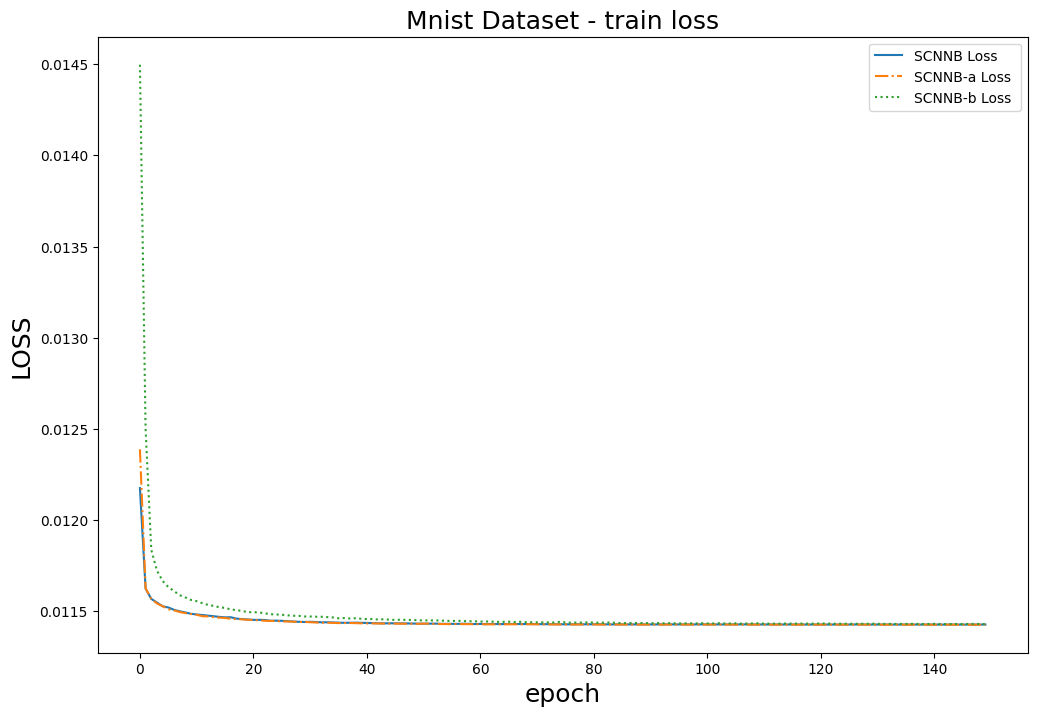

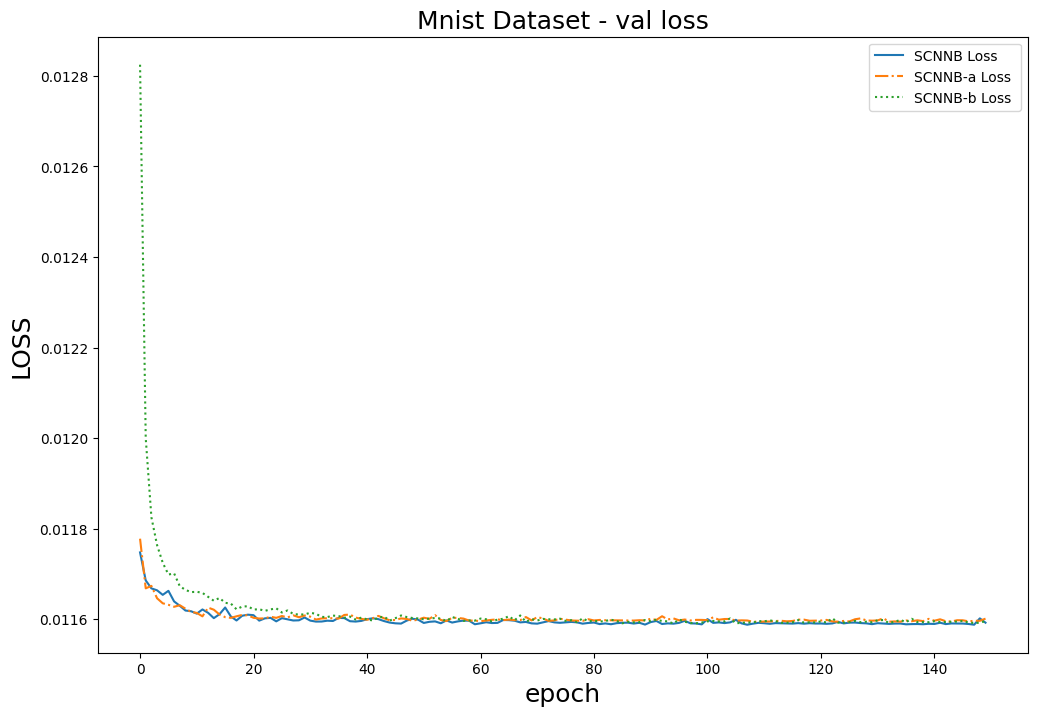

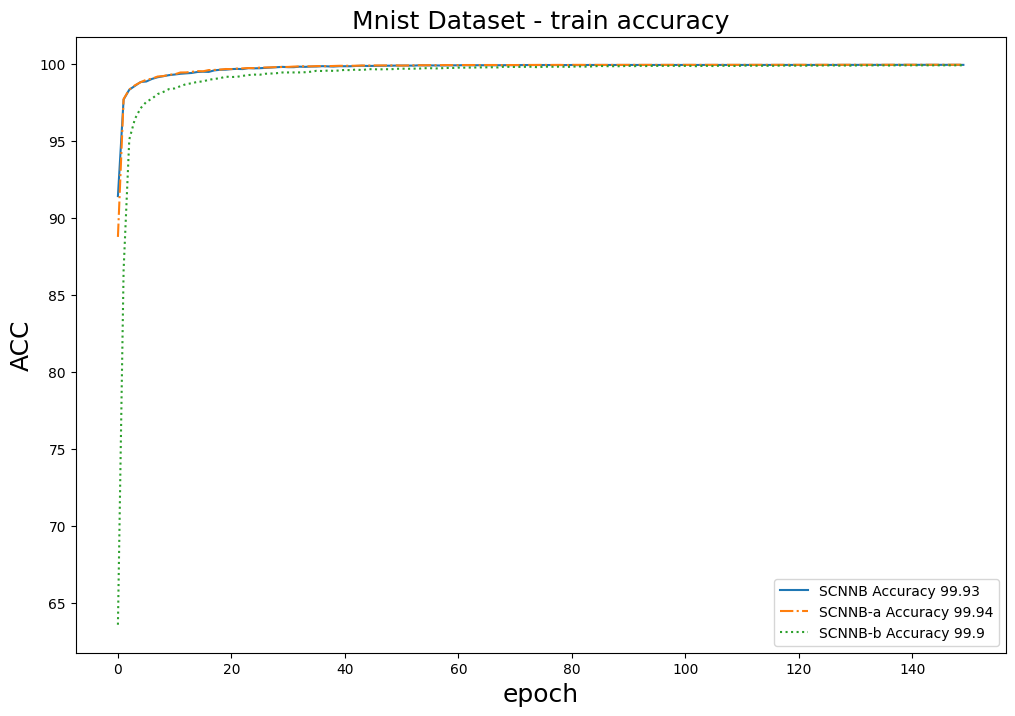

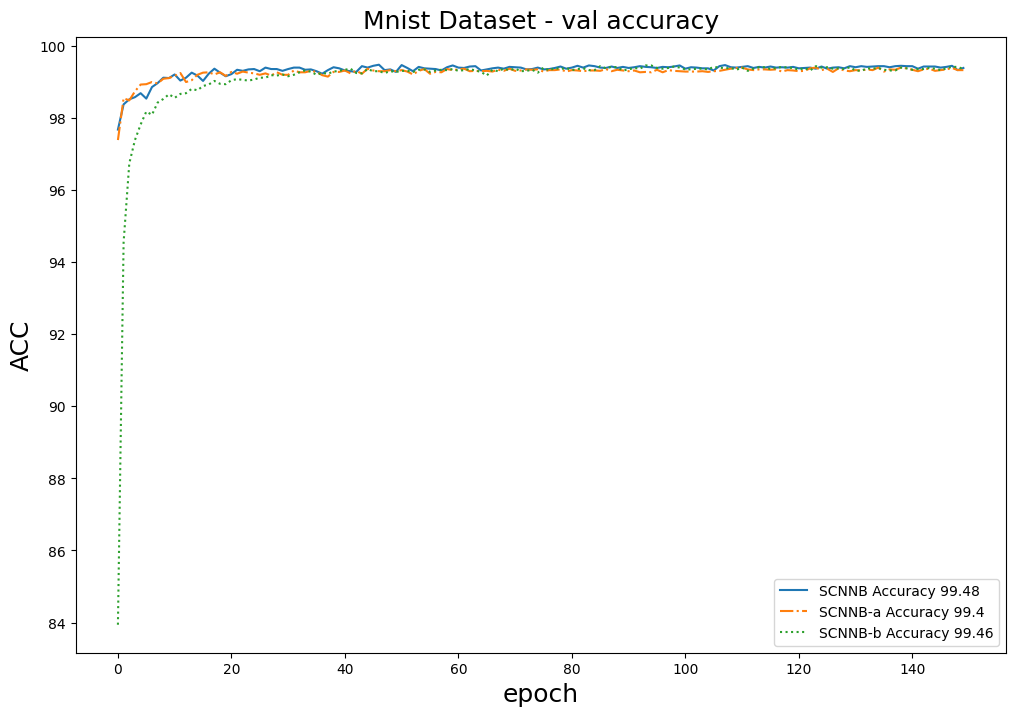

In [ ]:
plot3model(trainLoss1, trainLoss2, trainLoss3,description ="Mnist Dataset - train loss" , mode = "LOSS")
plot3model(valLoss1, valLoss2, valLoss3,description ="Mnist Dataset - val loss" , mode = "LOSS")
plot3model(trainAcc1, trainAcc2, trainAcc3,description ="Mnist Dataset - train accuracy" , mode = "ACC")
plot3model(valAcc1, valAcc2, valAcc3,description ="Mnist Dataset - val accuracy" , mode = "ACC")


# Fashion Mnist

In [ ]:
Nepoch = 150

scnnb = SCNNB(28,1)
scnnb = scnnb.to(device)
summary(scnnb, (1,28,28), batch_size = -1)
optimizer = torch.optim.SGD(scnnb.parameters(), lr=0.02, momentum=0.9, weight_decay = 0.000005)
criterion = nn.CrossEntropyLoss()
trainLoss1, trainAcc1, valLoss1, valAcc1 = trainModel(model=scnnb, 
                                                      trainLoader = fashionmnisttrainLoader, 
                                                      testLoader= fashionmnistestLoader,
                                                      criterion=criterion,
                                                      optim= optimizer,
                                                      epochs = Nepoch)

scnnbA = SCNNB_A(28,1)
scnnbA = scnnbA.to(device)
summary(scnnbA, (1,28,28), batch_size = -1)
optimizer = torch.optim.SGD(scnnbA.parameters(), lr=0.02, momentum=0.9, weight_decay = 0.000005)
criterion = nn.CrossEntropyLoss()
trainLoss2, trainAcc2, valLoss2, valAcc2 = trainModel(model=scnnbA, 
                                                      trainLoader = fashionmnisttrainLoader, 
                                                      testLoader= fashionmnistestLoader,
                                                      criterion=criterion,
                                                      optim= optimizer,
                                                      epochs = Nepoch)

scnnbB = SCNNB_B(28,1)
scnnbB = scnnbB.to(device)
summary(scnnbB, (1,28,28), batch_size = -1)
optimizer = torch.optim.SGD(scnnbB.parameters(), lr=0.02, momentum=0.9, weight_decay = 0.000005)
criterion = nn.CrossEntropyLoss()
trainLoss3, trainAcc3, valLoss3, valAcc3 = trainModel(model=scnnbB, 
                                                      trainLoader = fashionmnisttrainLoader, 
                                                      testLoader= fashionmnistestLoader,
                                                      criterion=criterion,
                                                      optim= optimizer,
                                                      epochs = Nepoch)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Linear-9                 [-1, 1280]       4,015,360
             ReLU-10                 [-1, 1280]               0
          Dropout-11                 [-1, 1280]               0
           Linear-12                   [-1, 10]          12,810
Total params: 4,047,178
Trainable params: 4,047,178
Non-trainable params: 0
---------------------------

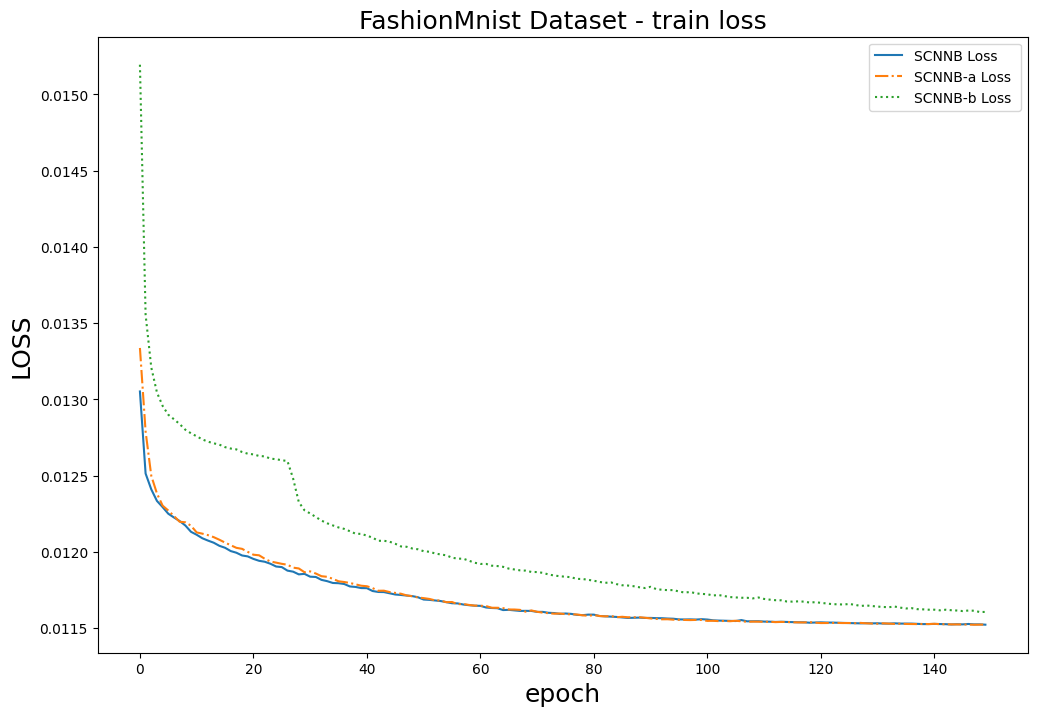

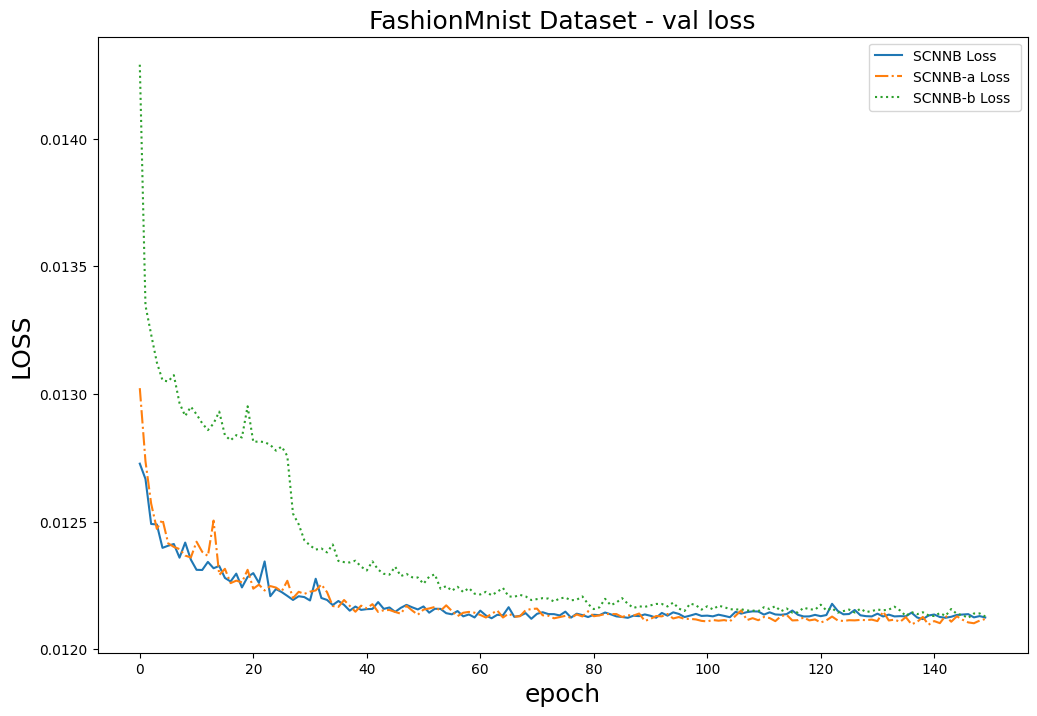

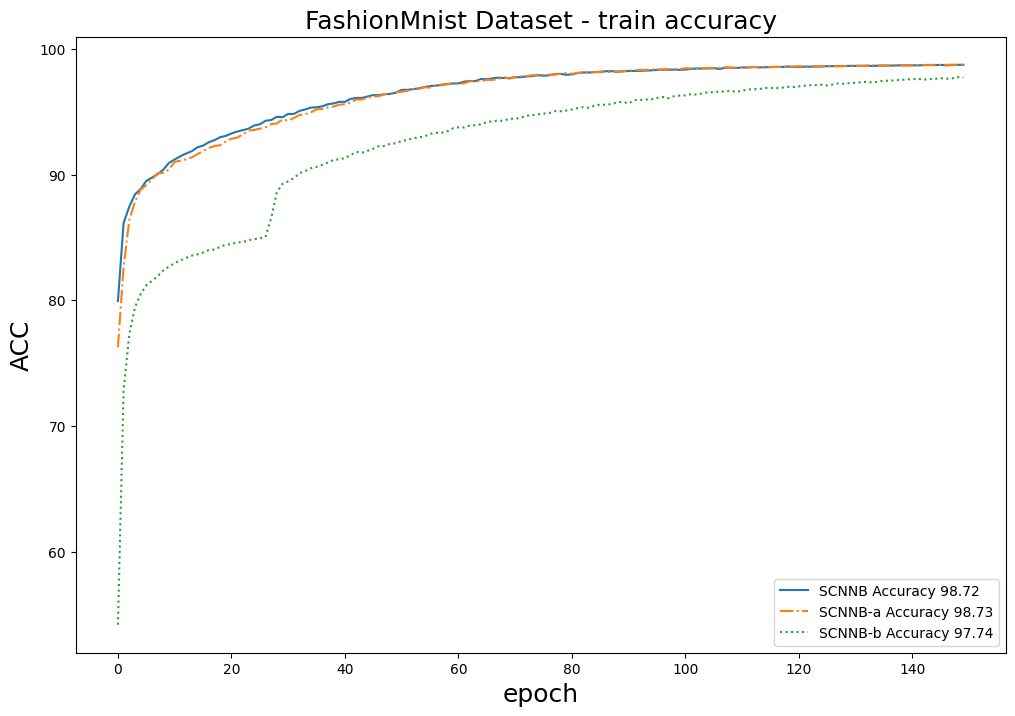

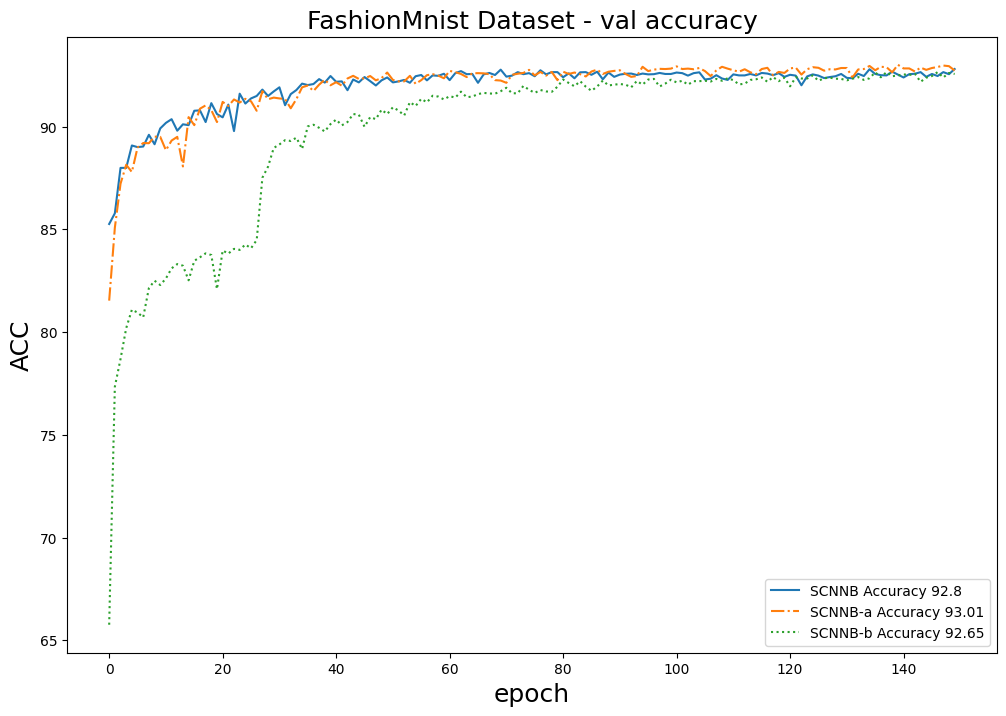

In [ ]:
plot3model(trainLoss1, trainLoss2, trainLoss3,description ="FashionMnist Dataset - train loss" , mode = "LOSS")
plot3model(valLoss1, valLoss2, valLoss3,description ="FashionMnist Dataset - val loss" , mode = "LOSS")
plot3model(trainAcc1, trainAcc2, trainAcc3,description ="FashionMnist Dataset - train accuracy" , mode = "ACC")
plot3model(valAcc1, valAcc2, valAcc3,description ="FashionMnist Dataset - val accuracy" , mode = "ACC")

# CFAR10

In [ ]:
Nepoch = 150

scnnb = SCNNB(32,3)
scnnb = scnnb.to(device)
summary(scnnb, (3,32,32), batch_size = -1)
optimizer = torch.optim.SGD(scnnb.parameters(), lr=0.02, momentum=0.9, weight_decay = 0.000005)
criterion = nn.CrossEntropyLoss()
trainLoss1, trainAcc1, valLoss1, valAcc1 = trainModel(model=scnnb, 
                                                      trainLoader = cfar10trainLoader , 
                                                      testLoader= cfar10testLoader,
                                                      criterion=criterion,
                                                      optim= optimizer,
                                                      epochs = Nepoch)

scnnbA = SCNNB_A(32,3)
scnnbA = scnnbA.to(device)
summary(scnnbA, (3,32,32), batch_size = -1)
optimizer = torch.optim.SGD(scnnbA.parameters(), lr=0.02, momentum=0.9, weight_decay = 0.000005)
criterion = nn.CrossEntropyLoss()
trainLoss2, trainAcc2, valLoss2, valAcc2 = trainModel(model=scnnbA, 
                                                      trainLoader = cfar10trainLoader, 
                                                      testLoader= cfar10testLoader,
                                                      criterion=criterion,
                                                      optim= optimizer,
                                                      epochs = Nepoch)

scnnbB = SCNNB_B(32,3)
scnnbB = scnnbB.to(device)
summary(scnnbB, (3,32,32), batch_size = -1)
optimizer = torch.optim.SGD(scnnbB.parameters(), lr=0.02, momentum=0.9, weight_decay = 0.000005)
criterion = nn.CrossEntropyLoss()
trainLoss3, trainAcc3, valLoss3, valAcc3 = trainModel(model=scnnbB, 
                                                      trainLoader = cfar10trainLoader, 
                                                      testLoader= cfar10testLoader,
                                                      criterion=criterion,
                                                      optim= optimizer,
                                                      epochs = Nepoch)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Linear-9                 [-1, 1280]       4,015,360
             ReLU-10                 [-1, 1280]               0
          Dropout-11                 [-1, 1280]               0
           Linear-12                   [-1, 10]          12,810
Total params: 4,047,754
Trainable params: 4,047,754
Non-trainable params: 0
---------------------------

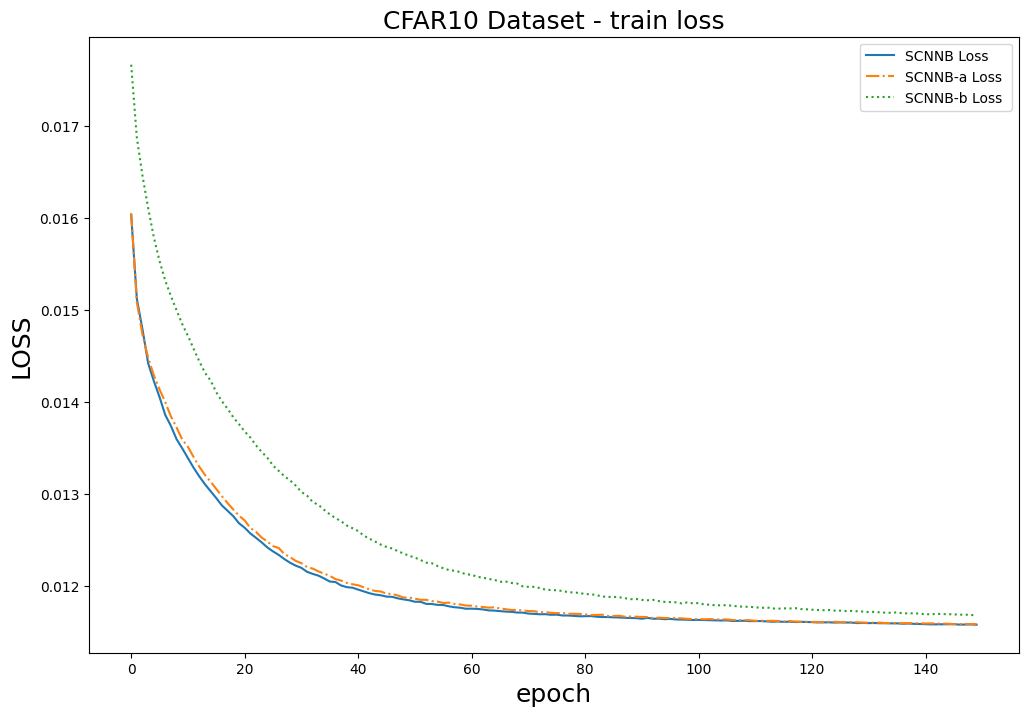

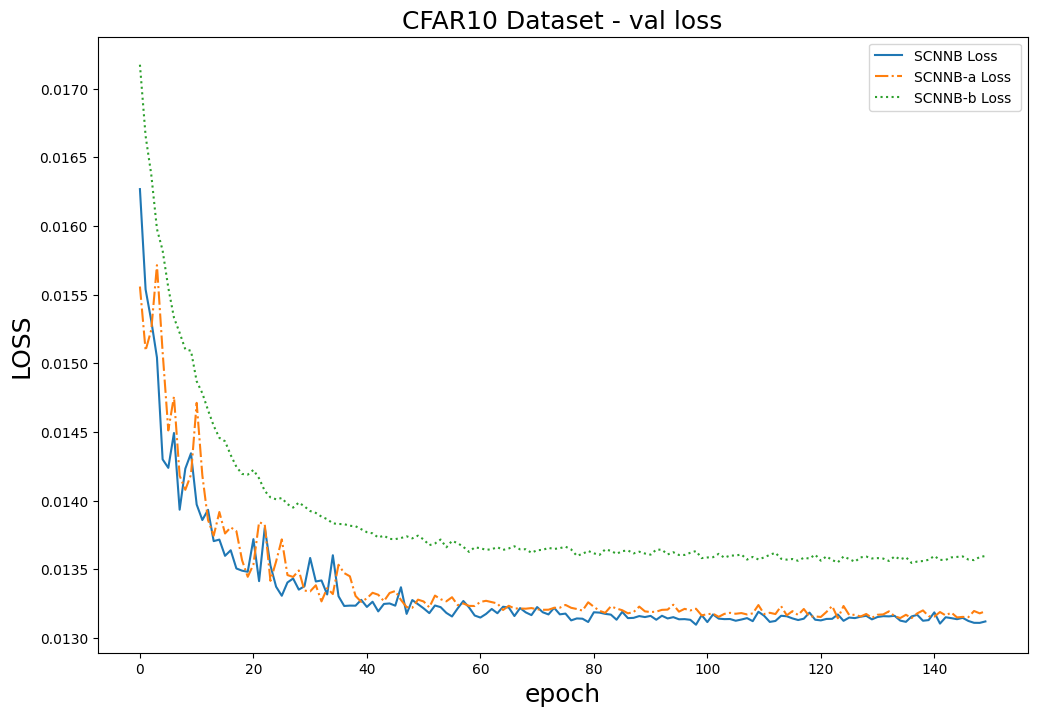

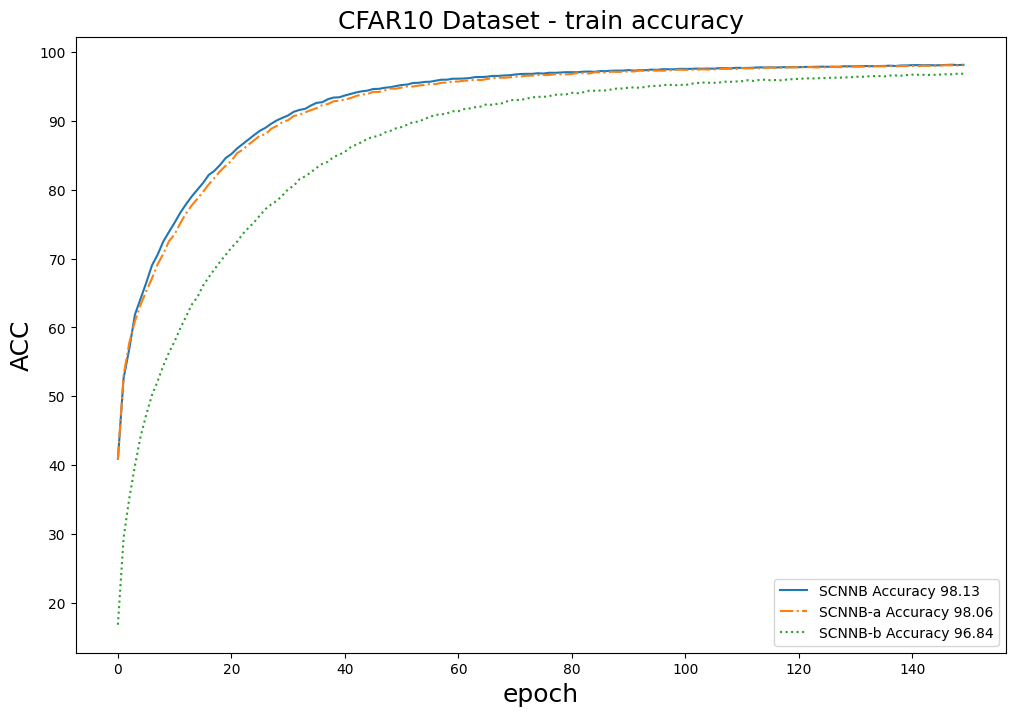

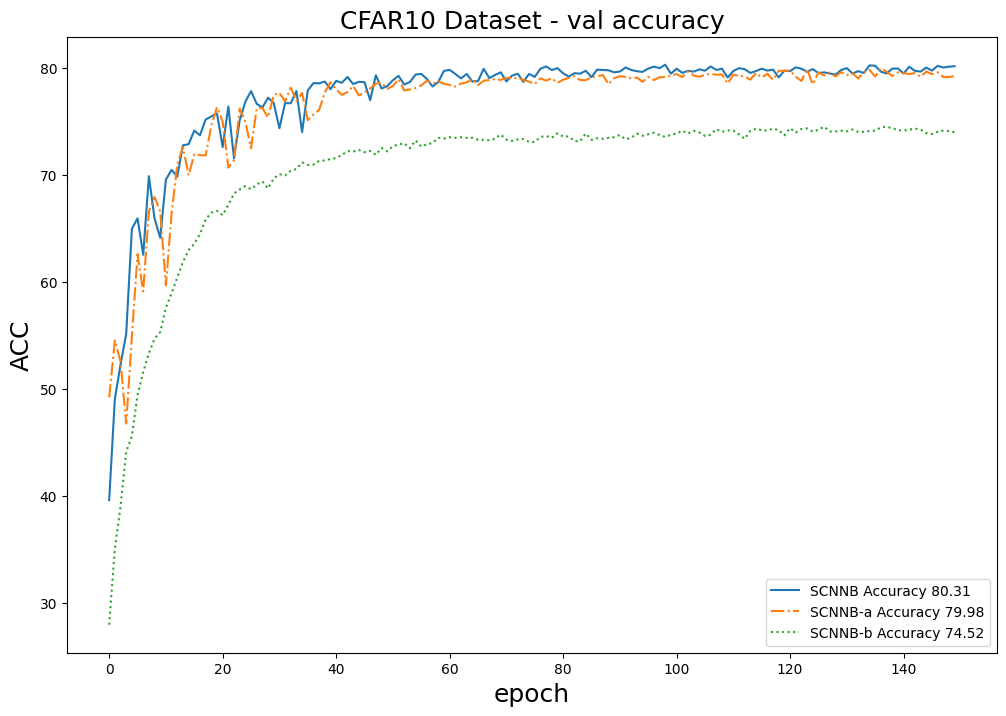

In [ ]:
plot3model(trainLoss1, trainLoss2, trainLoss3,description ="CFAR10 Dataset - train loss" , mode = "LOSS")
plot3model(valLoss1, valLoss2, valLoss3,description ="CFAR10 Dataset - val loss" , mode = "LOSS")
plot3model(trainAcc1, trainAcc2, trainAcc3,description ="CFAR10 Dataset - train accuracy" , mode = "ACC")
plot3model(valAcc1, valAcc2, valAcc3,description ="CFAR10 Dataset - val accuracy" , mode = "ACC")